In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import time
import os
import ldspec
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from statsmodels.stats.multitest import multipletests
from matplotlib import gridspec
import seaborn as sns
import statsmodels.formula.api as smf
from adjustText import adjust_text

# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
DATA_PATH = '/n/groups/price/martin/LDSPEC_data/UKBimp_337K_MAF001_chimp'
FIG_PATH = '/n/groups/price/martin/LDSPEC_data/results/fig_res'
TAB_PATH = '/n/groups/price/martin/LDSPEC_data/results/tables'

# DF_TRAIT, DF_ANNOT, DF_PANNOT
DF_TRAIT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/trait_info.tsv', sep='\t')
DF_TRAIT.index = DF_TRAIT['Trait_Identifier']
TRAIT_LIST = list(DF_TRAIT.index)
TRAIT_LIST_INDPT = list(DF_TRAIT.index[DF_TRAIT['Indpt']])
print("n_trait=%d" % DF_TRAIT.shape[0])
print("n_trait_indpt=%d" % len(TRAIT_LIST_INDPT))

DF_ANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/annot_info.tsv', sep='\t')
DF_ANNOT.index = DF_ANNOT['Identifier']
print("n_annot=%d" % DF_ANNOT.shape[0])

DF_PANNOT = pd.read_csv('/n/groups/price/martin/LDSPEC_data/results/tables/pannot_info.tsv', sep='\t')
DF_PANNOT.index = DF_PANNOT['Identifier']
print("n_pannot=%d" % DF_PANNOT.shape[0])

# Others
temp_df = pd.read_csv('../names.tsv', sep='\t', header=None)
DIC_NAME = {x:y for x,y in zip(temp_df[0], temp_df[1])}
DIC_COLOR = {
    'common' : '#78ADD2', 
    'lf' : '#FFB26E',
    ('p0_p100', 'common') : 'C0',
    ('p0_p100', 'lf') : 'C1',
    ('n100_p0', 'common') : 'C2',
    ('n100_p0', 'lf') : 'C3',
}

MARKER_LIST=['o', 'v', '^', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', '<', '>']

n_trait=70
n_trait_indpt=29
n_annot=45
n_pannot=34


### Load results and meta-analysis

In [3]:
# Load results 
DIC_RES_PATH = {
    'md_bsl' : DATA_PATH + '/ldspec_res_092223.bsl/@t',
    'md_prox_gene_fct_all_ld' : DATA_PATH + '/ldspec_res_092223.prox_gene_fct_all_ld/@t',
}
md0 = 'md_bsl'

# Load .pickle files: dic_res[md][trait] = .pickle
dic_res = {}
missing_list = []
for md in DIC_RES_PATH:
    dic_res[md] = {}   
    temp_list = TRAIT_LIST if md=='md_prox_gene_fct_all_ld' else TRAIT_LIST_INDPT
    for i,trait in enumerate(temp_list):
        if os.path.exists(DIC_RES_PATH[md].replace("@t", trait) + ".pickle"):
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".pickle", "br") as f:
                dic_res[md][trait] = pickle.load(f)
            # Check avgr
            with open(DIC_RES_PATH[md].replace("@t", trait) + ".sbatch.log", "r") as f:
                for line in f:
                    if 'Detected AVGR for' in line:
                        line = line.strip()
                        n1,n2 = line.split(' ')[3].split('/')
                        if n1!=n2: 
                            print("Missing AVGR: %-20s %-35s %s %s" % (md, trait, i+1, line))
        else:
            print("Missing %-10s %-30s %s" % (md, trait, i+1))
            if trait not in missing_list: 
                missing_list.append(trait)
                
# Check AN_list and pAN_list are same across traits for a given method
print('Check matching of AN_list and pAN_list')
for md in DIC_RES_PATH:
    print('    %s' % md)
    AN_list_md = list(dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['tau'].index)
    pAN_list_md = list(dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['omega'].index)
    for trait in dic_res[md]:
        if set(dic_res[md][trait]['summary']['tau'].index) != set(AN_list_md):
            print('    AN_list not match: %s' % trait)
        if set(dic_res[md][trait]['summary']['omega'].index) != set(pAN_list_md):
            print('    pAN_list not match: %s' % trait)

# Collect info
print('n_missing_trait=%d' % len(missing_list))
AN_list = list(dic_res[md0][TRAIT_LIST_INDPT[0]]['summary']['tau'].index)
print('AN_list=%d' % len(AN_list))
pAN_list = []
for md in DIC_RES_PATH:
    pAN_list += [x for x in dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['omega'].index if x not in pAN_list]
print('pAN_list=%d' % len(pAN_list))

# Trait with h2_z>5
TRAIT_LIST_META = []
for trait in TRAIT_LIST_INDPT:
    h2 = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2']
    h2_se = dic_res[md0][trait]['summary']['tau'].loc['AN:all', 'h2_se']
    h2_z = h2 / h2_se
    if h2_z > 5:
        TRAIT_LIST_META.append(trait)
    else:
        print('    %-20s    h2=%0.3f    h2_z=%0.2f' % (trait, h2, h2_z))
print('%d/%d traits with h2z>5' % (len(TRAIT_LIST_META), len(TRAIT_LIST_INDPT)))

Check matching of AN_list and pAN_list
    md_bsl
    md_prox_gene_fct_all_ld
n_missing_trait=0
AN_list=165
pAN_list=136
29/29 traits with h2z>5


In [4]:
# Meta-analysis
dic_term_list = {
    'tau': ['tau', 'h2', 'scv', 'h2_enrich', 'scv_enrich', 'h2_shrink'], 
    'omega': ['omega', 'cov', 'cor', 'ecov', 'ecor'],
}

dic_res_meta = {}
for md in DIC_RES_PATH:
    dic_res_meta[md] = {}
    res_tau_list = [dic_res[md][x]['summary']['tau'] for x in TRAIT_LIST_META]
    res_omega_list = [dic_res[md][x]['summary']['omega'] for x in TRAIT_LIST_META]
    for res in ['tau', 'omega']:
        dic_res_meta[md][res] = pd.DataFrame(
            index = dic_res[md][TRAIT_LIST_INDPT[0]]['summary'][res].index, 
            columns = ['%s%s'%(x,y) for x in dic_term_list[res] for y in ['', '_se', '_p']],
            dtype=float,
        )
        # Meta-analysis 
        for term in dic_term_list[res]:
            for row in dic_res_meta[md][res].index:
                mean_,se_,p_ = ldspec.util.ldspec_meta(res_tau_list, res_omega_list, term, row)
                dic_res_meta[md][res].loc[row, [term, '%s_se'%term, '%s_p'%term]] = mean_,se_,p_

/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:122: RuntimeWarning: overflow encountered in multiply
  varsum = np.sum(wt * wt * (variances + tau2)) / (np.sum(wt) ** 2)
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:102: RuntimeWarning: divide by zero encountered in true_divide
  vwts = 1.0 / variances
/home/jz286/WES_analysis/LDSPEC/ldspec/util.py:106: RuntimeWarning: invalid value encountered in float_scalars
  tau2 = np.maximum(0, (Q - df) / (vwts.sum() - vwts.dot(vwts) / vwts.sum()))


### h2_enrich vs. ecor

In [5]:
dic_name = {
    ('p0_p100', 'common') : 'common pos-LD',
    ('p0_p100', 'lf') : 'low-freq pos-LD',
    ('n100_p0', 'common') : 'common neg-LD',
    ('n100_p0', 'lf') : 'low-freq neg-LD',
    ('p0_p100', 'common', 'marker') : 'o',
    ('p0_p100', 'lf', 'marker') : '^',
    ('n100_p0', 'common', 'marker') : 'D',
    ('n100_p0', 'lf', 'marker') : 's',
}
md = 'md_prox_gene_fct_all_ld'
res1,term1,null_val1 = 'tau','h2_enrich',1 # res1 is h2_enrich
res2,term2,null_val2 = 'omega','ecor',0 # res2 is ecor

In [6]:
df_jn = pd.DataFrame(
    index=[(x,y,z) for x in ['0_100', '0_1000'] for y in ['p0_p100', 'n100_p0'] for z in ['common', 'lf']], 
    columns=['sl', 'sl_se', 'sl_p'], dtype=float,
)
for dbin in ['0_100', '0_1000']:
    for lbin in ['p0_p100', 'n100_p0']:
        for mbin in ['common', 'lf']:
            if dbin == '0_100':
                plot_list = [
                    x.replace('_proxy_0_100','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-100']
                ]
            if dbin == '0_1000':
                plot_list = [
                    x.replace('_proxy_0_1000','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-1k']
                ]                   
            print((dbin, lbin, mbin), len(plot_list))
                
            # Compute sl for each JN block 
            v_h = dic_res[md][TRAIT_LIST_INDPT[0]]['summary']['dic_jn']['v_h']
            sl_jn_list = []
            for i_block in range(v_h.shape[0]):
                temp_df = pd.DataFrame(index=plot_list, columns=['mean1', 'mean2'], dtype=float)
                for row in temp_df.index:
                    # mean across traits
                    row_name1 = 'AN:%s_%s'%(row,mbin) 
                    row_name2 = 'pAN:%s_proxy_%s_ld_%s_maf_%s_block'%(row,dbin,lbin,mbin)
                    v_mean = [
                        {x:y for x,y in zip(
                            dic_res[md][x]['summary']['dic_jn']['res_AN_list'],
                            dic_res[md][x]['summary']['dic_jn']['h2_enrich.jn'][i_block])}[row_name1]
                        for x in TRAIT_LIST_INDPT
                    ]
                    temp_df.loc[row, 'mean1'] = np.mean(v_mean)
                    v_mean = [
                        {x:y for x,y in zip(
                            dic_res[md][x]['summary']['dic_jn']['res_pAN_list'],
                            dic_res[md][x]['summary']['dic_jn']['cor.jn'][i_block])}[row_name2]
                        for x in TRAIT_LIST_INDPT
                    ]
                    temp_df.loc[row, 'mean2'] = np.mean(v_mean)
                    
                temp_df['mean1_adj'] = temp_df['mean1']-null_val1
                temp_df['mean2_adj'] = temp_df['mean2']-null_val2                          
                res = smf.ols("mean2_adj ~ mean1_adj - 1", temp_df).fit()
                sl,sl_se = res.params[0],res.bse[0]
                sl_jn_list.append(sl)
            
            # sl from full estimate
            temp_df = pd.DataFrame(index=plot_list, columns=['mean1', 'mean2'], dtype=float)
            for row in temp_df.index:
                row_name1 = 'AN:%s_%s'%(row,mbin) 
                row_name2 = 'pAN:%s_proxy_%s_ld_%s_maf_%s_block'%(row,dbin,lbin,mbin)
                v_mean = [
                    {x:y for x,y in zip(
                        dic_res[md][x]['summary']['dic_jn']['res_AN_list'],
                        dic_res[md][x]['summary']['dic_jn']['h2_enrich'])}[row_name1]
                    for x in TRAIT_LIST_INDPT
                ]
                temp_df.loc[row, 'mean1'] = np.mean(v_mean)
                v_mean = [
                    {x:y for x,y in zip(
                        dic_res[md][x]['summary']['dic_jn']['res_pAN_list'],
                        dic_res[md][x]['summary']['dic_jn']['cor'])}[row_name2]
                    for x in TRAIT_LIST_INDPT
                ]
                temp_df.loc[row, 'mean2'] = np.mean(v_mean)

            temp_df['mean1_adj'] = temp_df['mean1']-null_val1
            temp_df['mean2_adj'] = temp_df['mean2']-null_val2                          
            res = smf.ols("mean2_adj ~ mean1_adj - 1", temp_df).fit()
            sl,sl_se = res.params[0],res.bse[0]
            
            v_mean_jn, mat_cov_jn = ldspec.regress.bjn([sl], sl_jn_list, v_h)
            sl = v_mean_jn[0]
            sl_se = np.sqrt(mat_cov_jn[0,0])
            sl_p = ldspec.util.zsc2pval(sl / sl_se)
            df_jn.loc[[(dbin, lbin, mbin)]] = [[sl, sl_se, sl_p]]

df_jn['sl_fwer'] = df_jn['sl_p'] * df_jn.shape[0]
df_jn.to_csv(TAB_PATH+'/fig4.tsv', sep='\t')
display(df_jn)

('0_100', 'p0_p100', 'common') 7
('0_100', 'p0_p100', 'lf') 7
('0_100', 'n100_p0', 'common') 7
('0_100', 'n100_p0', 'lf') 7
('0_1000', 'p0_p100', 'common') 19
('0_1000', 'p0_p100', 'lf') 19
('0_1000', 'n100_p0', 'common') 19
('0_1000', 'n100_p0', 'lf') 19


,sl,sl_se,sl_p,sl_fwer
"(0_100, p0_p100, common)",-0.023406,0.043443,5.900328e-01,4.720262e+00
"(0_100, p0_p100, lf)",-0.267127,0.228043,2.414420e-01,1.931536e+00
"(0_100, n100_p0, common)",0.036937,0.058467,5.275466e-01,4.220373e+00
"(0_100, n100_p0, lf)",-0.311449,0.234520,1.841684e-01,1.473347e+00
"(0_1000, p0_p100, common)",-0.024240,0.009337,9.426431e-03,7.541145e-02
"(0_1000, p0_p100, lf)",-0.178927,0.030813,6.366201e-09,5.092961e-08
"(0_1000, n100_p0, common)",0.035990,0.009641,1.893535e-04,1.514828e-03
"(0_1000, n100_p0, lf)",-0.041215,0.028820,1.526901e-01,1.221521e+00


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


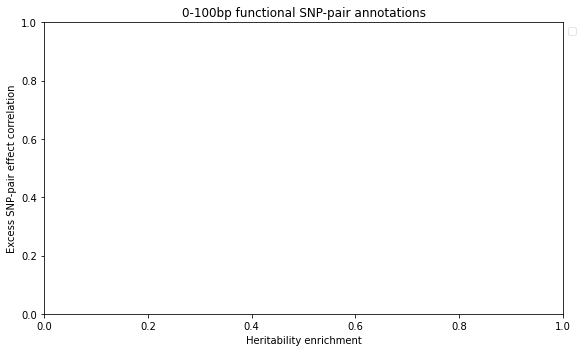

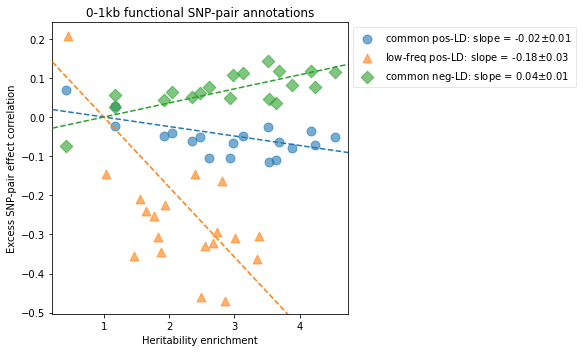

In [7]:
for dbin in ['0_100', '0_1000']:
    if dbin == '0_100':
        plot_list = [x.replace('_proxy_0_100','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-100']]
    if dbin == '0_1000':
        plot_list = [x.replace('_proxy_0_1000','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-1k']]
    df_plot = pd.DataFrame(
        index=['%s.%s.%s'%(x,y,z) for x in plot_list for y in ['p0_p100', 'n100_p0'] for z in ['common', 'lf']],
        columns=['mean1', 'se1', 'mean2', 'se2'], dtype=float,
    )
    for row in df_plot.index:
        annot,lbin,mbin = row.split('.')
        row_name1 = 'AN:%s_%s'%(annot,mbin) 
        row_name2 = 'pAN:%s_proxy_%s_ld_%s_maf_%s_block'%(annot,dbin,lbin,mbin)
        if row_name1 in dic_res_meta[md][res1].index:
            df_plot.loc[row, 'mean1'] = dic_res_meta[md][res1].loc[row_name1, term1]
            df_plot.loc[row, 'se1'] = dic_res_meta[md][res1].loc[row_name1, '%s_se'%term1]
        if row_name2 in dic_res_meta[md][res2].index:
            df_plot.loc[row, 'mean2'] = dic_res_meta[md][res2].loc[row_name2, term2]
            df_plot.loc[row, 'se2'] = dic_res_meta[md][res2].loc[row_name2, '%s_se'%term2]
    df_plot['mean1_adj'] = df_plot['mean1']-null_val1
    df_plot['mean2_adj'] = df_plot['mean2']-null_val2
    
    if dbin == '0_1000':
        temp_df = df_plot[['mean1', 'se1', 'mean2', 'se2']].copy()
        temp_df.columns = ['h2_enrich', 'h2_enrich_se', 'ecor', 'ecor_se']
        temp_df.to_csv(TAB_PATH+'/fig4.tsv', sep='\t')
    
    plt.figure(figsize=[8.2,5])
    for lbin in ['p0_p100', 'n100_p0']:
        for mbin in ['common', 'lf']:
            temp_list = ['%s.%s.%s'%(x,lbin,mbin) for x in plot_list]   
            sl,sl_se,sl_p = df_jn.loc[[(dbin, lbin, mbin)], ['sl', 'sl_se', 'sl_p']].values[0] 
            if sl_p>=0.05/4:
                continue
            eq_str = '%0.2f$\pm$%0.2f' % (sl,sl_se)
            plt.scatter(
                df_plot.loc[temp_list, 'mean1'], df_plot.loc[temp_list, 'mean2'], 
                marker=dic_name[(lbin, mbin, 'marker')], s=80,
                alpha=0.6, color=DIC_COLOR[(lbin, mbin)], 
                label='%s: slope = %s'%(dic_name[(lbin, mbin)], eq_str), zorder=5,
            )

    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    for lbin in ['p0_p100', 'n100_p0']:
        for mbin in ['common', 'lf']:
            temp_list = ['%s.%s.%s'%(x,lbin,mbin) for x in plot_list]
            sl,sl_se,sl_p = df_jn.loc[[(dbin, lbin, mbin)], ['sl', 'sl_se', 'sl_p']].values[0] 
            if sl_p>=0.05/4:
                continue
            icpt = -sl*null_val1 + null_val2
            plt.plot(
                [xmin, xmax], [xmin*sl+icpt, xmax*sl+icpt], '--', 
                linewidth=1.5, alpha=1, color=DIC_COLOR[(lbin, mbin)], zorder=10
            )

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.legend(loc='upper left', framealpha=0.5, bbox_to_anchor=(1, 1))
    if dbin == '0_100':
        plt.title('0-100bp functional SNP-pair annotations')
    if dbin == '0_1000':
        plt.title('0-1kb functional SNP-pair annotations')
    plt.xlabel('Heritability enrichment')
    plt.ylabel('Excess SNP-pair effect correlation')   
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/fig4.%s.pdf' % dbin)
    plt.show()

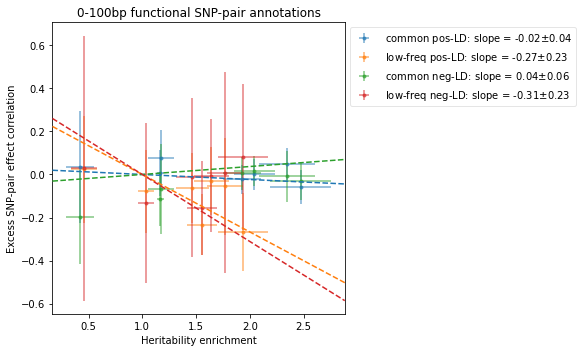

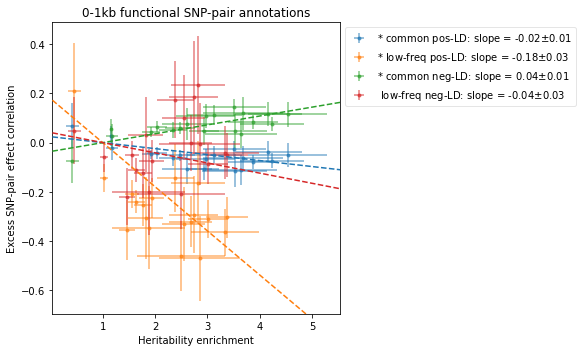

In [8]:
# Full
for dbin in ['0_100', '0_1000']:
    if dbin == '0_100':
        plot_list = [x.replace('_proxy_0_100','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-100']]
    if dbin == '0_1000':
        plot_list = [x.replace('_proxy_0_1000','') for x in DF_PANNOT.index[DF_PANNOT['Type']=='fct-1k']]
    df_plot = pd.DataFrame(
        index=['%s.%s.%s'%(x,y,z) for x in plot_list for y in ['p0_p100', 'n100_p0'] for z in ['common', 'lf']],
        columns=['mean1', 'se1', 'mean2', 'se2'], dtype=float,
    )
    for row in df_plot.index:
        annot,lbin,mbin = row.split('.')
        row_name1 = 'AN:%s_%s'%(annot,mbin) 
        row_name2 = 'pAN:%s_proxy_%s_ld_%s_maf_%s_block'%(annot,dbin,lbin,mbin)
        if row_name1 in dic_res_meta[md][res1].index:
            df_plot.loc[row, 'mean1'] = dic_res_meta[md][res1].loc[row_name1, term1]
            df_plot.loc[row, 'se1'] = dic_res_meta[md][res1].loc[row_name1, '%s_se'%term1]
        if row_name2 in dic_res_meta[md][res2].index:
            df_plot.loc[row, 'mean2'] = dic_res_meta[md][res2].loc[row_name2, term2]
            df_plot.loc[row, 'se2'] = dic_res_meta[md][res2].loc[row_name2, '%s_se'%term2]
    df_plot['mean1_adj'] = df_plot['mean1']-null_val1
    df_plot['mean2_adj'] = df_plot['mean2']-null_val2 
    
    plt.figure(figsize=[8.2,5])
    for lbin in ['p0_p100', 'n100_p0']:
        for mbin in ['common', 'lf']:
            temp_list = ['%s.%s.%s'%(x,lbin,mbin) for x in plot_list]   
            sl,sl_se,sl_p = df_jn.loc[[(dbin, lbin, mbin)], ['sl', 'sl_se', 'sl_p']].values[0]    
            sig_str = '*' if sl_p<0.05/4 else ''
            eq_str = '%0.2f$\pm$%0.2f' % (sl,sl_se)
            
            plt.errorbar(
                df_plot.loc[temp_list, 'mean1'], df_plot.loc[temp_list, 'mean2'], 
                xerr=df_plot.loc[temp_list, 'se1']*1.96, yerr=df_plot.loc[temp_list, 'se2']*1.96, 
                fmt= '.', alpha=0.6, color=DIC_COLOR[(lbin, mbin)], 
                label='%s %s: slope = %s'%(sig_str, dic_name[(lbin, mbin)], eq_str), zorder=5,
            )

    xmin,xmax = plt.xlim()
    ymin,ymax = plt.ylim()
    for lbin in ['p0_p100', 'n100_p0']:
        for mbin in ['common', 'lf']:
            temp_list = ['%s.%s.%s'%(x,lbin,mbin) for x in plot_list]
            sl,sl_se,sl_p = df_jn.loc[[(dbin, lbin, mbin)], ['sl', 'sl_se', 'sl_p']].values[0]   
            icpt = -sl*null_val1 + null_val2
            plt.plot(
                [xmin, xmax], [xmin*sl+icpt, xmax*sl+icpt], '--', 
                linewidth=1.5, color=DIC_COLOR[(lbin, mbin)], zorder=10
            )

    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])
    plt.legend(loc='upper left', framealpha=0.5, bbox_to_anchor=(1, 1))
    if dbin == '0_100':
        plt.title('0-100bp functional SNP-pair annotations')
    if dbin == '0_1000':
        plt.title('0-1kb functional SNP-pair annotations')
    plt.xlabel('Heritability enrichment')
    plt.ylabel('Excess SNP-pair effect correlation')   
    plt.tight_layout()
    plt.savefig(FIG_PATH + '/fig4.compare.%s.%s.%s.%s.pdf' % (term1,term2,md,dbin))
    plt.show()
#     break

### Old code